# Feature Selection & Scaling

@roman

21 July, 2024

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LassoCV, lasso_path
from sklearn.model_selection import train_test_split

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 500)
TODAY = pd.to_datetime('today')

---
# Data

## Read

In [3]:
# important columns
cols_to_stay = [
    'property_id', 'fecha_avaluo', 
    'id_clase_inmueble', 'id_tipo_inmueble', 'conservacion', 'elevador',
    'cve_ref_proximidad_urbana', 'valor_mercado', 'edad_anios',
    'cve_vigilancia', 'regimen_propiedad', 'tipo_vialidad', 'id_entidad_f',
    'recamaras', 'banos', 'medio_banos',
    'estacionamiento', 'superficie_terreno', 'superficie_construida',
    'superficie_accesoria', 'superficie_vendible',
    'city_cluster', 'distance_to_ocean', 'ocean_label', 'longitud', 'latitud',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km', 'count_restaurants_at_1km',
    'ing_cor', 'competitors_weighted_mean_log_price_per_sqm',
    'competitors_weighted_mean_log_price_per_sqm_lower',
    'competitors_weighted_mean_log_price_per_sqm_upper',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper'
]

# read database
df_properties = pd.read_parquet("../../data/clean/properties_shif.parquet").loc[:, cols_to_stay]

# set property_id as index
df_properties = df_properties.set_index('property_id')

# see
print(df_properties.shape)
df_properties.head(2)

(852913, 37)


,fecha_avaluo,id_clase_inmueble,id_tipo_inmueble,conservacion,elevador,cve_ref_proximidad_urbana,valor_mercado,edad_anios,cve_vigilancia,regimen_propiedad,tipo_vialidad,id_entidad_f,recamaras,banos,medio_banos,estacionamiento,superficie_terreno,superficie_construida,superficie_accesoria,superficie_vendible,city_cluster,distance_to_ocean,ocean_label,longitud,latitud,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,ing_cor,competitors_weighted_mean_log_price_per_sqm,competitors_weighted_mean_log_price_per_sqm_lower,competitors_weighted_mean_log_price_per_sqm_upper,mean_log_valor_fisico_terreno_m2,mean_log_valor_fisico_terreno_m2_lower,mean_log_valor_fisico_terreno_m2_upper
property_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66cf10199ef943a5a5ff82129e53d5d7,2020-05-27,4,2,4.0,1.0,1,4305275,25,NaN,PRIVADA INDIVIDUAL,NaN,09,2,1,0,0,143,348,0,348,0,inf,no_ocean,-99.158103,19.310875,2,12,0,0,7,75369.418453,9.719780,9.527069,9.912490,9.673058,8.712578,10.633539
f84f9a0c784f491eab6bb100b513a95b,2020-07-23,3,2,4.0,2.0,2,1351682,25,NaN,PRIVADA INDIVIDUAL,NaN,15,2,2,0,1,113,108,0,108,0,inf,no_ocean,-99.065361,19.491722,0,4,0,0,0,40971.566919,9.565254,9.401056,9.729452,9.002990,8.205054,9.800925


## Wrangling

### NaNs

In [4]:
# nan values
df_properties.isna().mean()[df_properties.isna().mean().gt(0)]

elevador                                             0.033259
cve_vigilancia                                       0.371019
tipo_vialidad                                        0.371019
competitors_weighted_mean_log_price_per_sqm          0.143140
competitors_weighted_mean_log_price_per_sqm_lower    0.143140
competitors_weighted_mean_log_price_per_sqm_upper    0.143140
dtype: float64

In [5]:
# fill with 0's
df_properties['elevador'] = df_properties['elevador'].fillna(0)
df_properties['cve_vigilancia'] = df_properties['cve_vigilancia'].fillna(0)
df_properties['tipo_vialidad'] = df_properties['tipo_vialidad'].fillna(0)

In [6]:
# competitors with terrain value
df_properties['competitors_weighted_mean_log_price_per_sqm'] = df_properties['competitors_weighted_mean_log_price_per_sqm'].combine_first(df_properties['mean_log_valor_fisico_terreno_m2'])
df_properties['competitors_weighted_mean_log_price_per_sqm_lower'] = df_properties['competitors_weighted_mean_log_price_per_sqm_lower'].combine_first(df_properties['mean_log_valor_fisico_terreno_m2_lower'])
df_properties['competitors_weighted_mean_log_price_per_sqm_upper'] = df_properties['competitors_weighted_mean_log_price_per_sqm_upper'].combine_first(df_properties['mean_log_valor_fisico_terreno_m2_upper'])

In [7]:
# nan values
df_properties.isna().mean()[df_properties.isna().mean().gt(0)]

Series([], dtype: float64)

### Casting

In [8]:
# integer columns
columns_to_integer = [
    'cve_vigilancia', 'tipo_vialidad', 
]

# to int (downcast)
df_properties[columns_to_integer] = df_properties[columns_to_integer].astype('float').round().astype('Int64')

## Feature Engineering

In [9]:
# params
first_date_obs = df_properties['fecha_avaluo'].min()
last_date_obs = df_properties['fecha_avaluo'].max()

# create columns
df_properties = (
    df_properties
    .assign(
        # objective variable
        price_per_sqm=lambda x: x['valor_mercado'] / x['superficie_vendible'],
        # quarters since appraisal
        quarters_since_first_appraisal=lambda x: (x['fecha_avaluo'] - first_date_obs).dt.days / (30.4 * 3),
        # recategorizations
        elevador_recat=lambda x: x['elevador'].ge(1).astype(int),
        is_new=lambda x: x['edad_anios'].le(2).astype(int),
        recamaras_recat=lambda x: x['recamaras'].clip(0, 5),
        banos_recat=lambda x: x['banos'].clip(0, 5),
        medio_banos_recat=lambda x: x['medio_banos'].clip(0, 5),
        estacionamiento_recat=lambda x: x['estacionamiento'].clip(0, 5),
        conservacion_recat=lambda x: x['conservacion'].replace({7: 3.5}) - x['conservacion'].min(),
        cve_vigilancia_recat=lambda x: np.where(x['cve_vigilancia'].eq(2), 1, 0),
        regimen_propiedad_colectiva=lambda x: x['regimen_propiedad'].eq('PRIVADA COLECTIVA').astype(int),
        distance_to_ocean_recat=lambda x: np.select(
            [
                x['distance_to_ocean'].le(500),
                x['distance_to_ocean'].le(50_000),
                x['distance_to_ocean'].gt(50_000)
            ],
            [2, 1, 0],
            default=0
        ),
        superficie_terreno_usable=lambda x: np.where(
            x['id_tipo_inmueble'].eq(4),
            x['superficie_accesoria'],
            x['superficie_terreno'] + x['superficie_accesoria']
        ),
    )
)

In [10]:
# count of unique values 
def count_unique_values(df, col, max_values=10):
    """
    Count the number of unique values in a column and return the result as a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        col (str): The column to analyze.
        max_values (int): The maximum number of unique values to display. If there are more unique values, they will be grouped in an 'Others' category.
    
    Returns:
        pd.DataFrame: A DataFrame with the count of unique values.
    """
    # counts
    table_counts = (
        df[col]
        .value_counts(dropna=False)
        .reset_index()
        .assign(
            perc=lambda x: x['count'] / x['count'].sum()
        )
        .sort_values(by='count', ascending=False)
        .head(max_values)
    )
    
    num_others = df.shape[0] - table_counts['count'].sum()

    # append others if necessary
    if num_others > 0:
        table_counts = pd.concat([
            table_counts,
            pd.DataFrame({
                col: 'others',
                'count': [num_others],
                'perc': [num_others / df.shape[0]]
            })
        ],
        axis=0,
        ignore_index=True
    )

    return table_counts

# counts of *_recat columns
cols_to_count = df_properties.columns[df_properties.columns.str.endswith('_recat')]
for col in cols_to_count:
    print(f"\n{col} {'=' * 50}")
    print(count_unique_values(df_properties, col, 10))


elevador_recat ==================================================
   elevador_recat   count      perc
0               1  655345  0.768361
1               0  197568  0.231639

recamaras_recat ==================================================
   recamaras_recat   count      perc
0                2  507904  0.595493
1                3  262386  0.307635
2                1   49373  0.057887
3                4   27305  0.032014
4                5    5945  0.006970

banos_recat ==================================================
   banos_recat   count      perc
0            1  574747  0.673864
1            2  199792  0.234247
2            3   55115  0.064620
3            4   17073  0.020017
4            5    6186  0.007253

medio_banos_recat ==================================================
   medio_banos_recat   count      perc
0                  0  584057  0.684779
1                  1  258541  0.303127
2                  2    9259  0.010856
3                  3     850  0.000997
4       

In [11]:
# see new var
df_properties['quarters_since_first_appraisal'].describe()

count    852913.000000
mean          9.362340
std           5.598605
min           0.000000
25%           4.484649
50%           9.221491
75%          14.155702
max          20.010965
Name: quarters_since_first_appraisal, dtype: float64

## Scaling

In [12]:
# scaling
df_properties = (
    df_properties
    .assign(
        # time
        edad_anios=lambda x: x['edad_anios'] / 10,
        # surfaces
        superficie_vendible=lambda x: np.log(x['superficie_vendible']),
        superficie_accesoria=lambda x: np.log(x['superficie_accesoria'] + 1),
        superficie_terreno_usable=lambda x: np.log(x['superficie_terreno_usable'] + 1),
        # counts
        count_supermarkets_at_1km=lambda x: np.sqrt(x['count_supermarkets_at_1km']),
        count_hospitals_at_5km=lambda x: np.sqrt(x['count_hospitals_at_5km']),
        count_metro_at_1km=lambda x: np.sqrt(x['count_metro_at_1km']),
        count_schools_at_1km=lambda x: np.sqrt(x['count_schools_at_1km']),
        count_restaurants_at_1km=lambda x: np.sqrt(x['count_restaurants_at_1km']),
        # ing
        ing_cor=lambda x: np.log(x['ing_cor']),
        # objective variable
        log_price_per_sqm=lambda x: np.log(x['price_per_sqm']),
    )
)

# see scales of variables
df_properties.describe().T[['mean', 'min', 'max']]

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,mean,min,max
fecha_avaluo,2021-05-03 20:17:26.748730624,2019-01-01 00:00:00,2023-12-31 00:00:00
id_clase_inmueble,3.477617,2.0,7.0
id_tipo_inmueble,2.755807,2.0,4.0
conservacion,5.086957,3.0,7.0
elevador,1.513819,0.0,2.0
cve_ref_proximidad_urbana,2.548603,1.0,5.0
valor_mercado,1394750.17684,199855.0,86765134.0
edad_anios,0.587464,0.0,10.0
cve_vigilancia,0.817797,0.0,3.0
tipo_vialidad,1.541761,0.0,8.0


## One hot encoding

In [13]:
# categories
columns_categorical = list(set([
    'city_cluster',
    'id_entidad_f',
    'id_tipo_inmueble',
    'ocean_label',
    'tipo_vialidad'
    ]))

# convert to category
df_properties[columns_categorical] = df_properties[columns_categorical].astype('category')


In [14]:
# one hot encoding
columns_to_one_hot = [
    'id_entidad_f',
    'id_tipo_inmueble'
]

# one hot encoding
df_properties = pd.get_dummies(df_properties, columns=columns_to_one_hot, drop_first=True, dtype='int')

# see columns
df_properties.columns

Index(['fecha_avaluo', 'id_clase_inmueble', 'conservacion', 'elevador',
       'cve_ref_proximidad_urbana', 'valor_mercado', 'edad_anios',
       'cve_vigilancia', 'regimen_propiedad', 'tipo_vialidad', 'recamaras',
       'banos', 'medio_banos', 'estacionamiento', 'superficie_terreno',
       'superficie_construida', 'superficie_accesoria', 'superficie_vendible',
       'city_cluster', 'distance_to_ocean', 'ocean_label', 'longitud',
       'latitud', 'count_supermarkets_at_1km', 'count_hospitals_at_5km',
       'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km', 'ing_cor',
       'competitors_weighted_mean_log_price_per_sqm',
       'competitors_weighted_mean_log_price_per_sqm_lower',
       'competitors_weighted_mean_log_price_per_sqm_upper',
       'mean_log_valor_fisico_terreno_m2',
       'mean_log_valor_fisico_terreno_m2_lower',
       'mean_log_valor_fisico_terreno_m2_upper', 'price_per_sqm',
       'quarters_since_first_appraisal', 'elevador_recat', 

---
# Feature Selection Lasso

## Split Data

In [15]:
# get important columns
cols_for_model = [
    'id_clase_inmueble',
    'edad_anios',
    'cve_vigilancia', 
    'superficie_accesoria',
    'superficie_vendible',
    'count_supermarkets_at_1km',
    'count_hospitals_at_5km',
    'count_metro_at_1km',
    'count_schools_at_1km',
    'count_restaurants_at_1km',
    'ing_cor',
    'competitors_weighted_mean_log_price_per_sqm',
    'competitors_weighted_mean_log_price_per_sqm_lower',
    'competitors_weighted_mean_log_price_per_sqm_upper',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper', 
    'quarters_since_first_appraisal',
    'elevador_recat',
    'is_new',
    'recamaras_recat',
    'banos_recat',
    'medio_banos_recat',
    'estacionamiento_recat',
    'conservacion_recat',
    'cve_vigilancia_recat',
    'regimen_propiedad_colectiva',
    'distance_to_ocean_recat',
    'superficie_terreno_usable',
    'id_entidad_f_02',
    'id_entidad_f_03',
    'id_entidad_f_04',
    'id_entidad_f_05',
    'id_entidad_f_06',
    'id_entidad_f_07',
    'id_entidad_f_08',
    'id_entidad_f_09',
    'id_entidad_f_10',
    'id_entidad_f_11',
    'id_entidad_f_12',
    'id_entidad_f_13',
    'id_entidad_f_14',
    'id_entidad_f_15',
    'id_entidad_f_16',
    'id_entidad_f_17',
    'id_entidad_f_18',
    'id_entidad_f_19',
    'id_entidad_f_20',
    'id_entidad_f_21',
    'id_entidad_f_22',
    'id_entidad_f_23',
    'id_entidad_f_24',
    'id_entidad_f_25',
    'id_entidad_f_26',
    'id_entidad_f_27',
    'id_entidad_f_28',
    'id_entidad_f_29',
    'id_entidad_f_30',
    'id_entidad_f_31',
    'id_entidad_f_32',
    'id_tipo_inmueble_3',
    'id_tipo_inmueble_4'
]

X = df_properties[cols_for_model].copy()
y = df_properties['log_price_per_sqm'].copy()

In [16]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=df_properties['id_tipo_inmueble_4']  # same proportion of apartments
    )

In [17]:
# see
X_train

,id_clase_inmueble,edad_anios,cve_vigilancia,superficie_accesoria,superficie_vendible,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,ing_cor,competitors_weighted_mean_log_price_per_sqm,competitors_weighted_mean_log_price_per_sqm_lower,competitors_weighted_mean_log_price_per_sqm_upper,mean_log_valor_fisico_terreno_m2,mean_log_valor_fisico_terreno_m2_lower,mean_log_valor_fisico_terreno_m2_upper,quarters_since_first_appraisal,elevador_recat,is_new,recamaras_recat,banos_recat,medio_banos_recat,estacionamiento_recat,conservacion_recat,cve_vigilancia_recat,regimen_propiedad_colectiva,distance_to_ocean_recat,superficie_terreno_usable,id_entidad_f_02,id_entidad_f_03,id_entidad_f_04,id_entidad_f_05,id_entidad_f_06,id_entidad_f_07,id_entidad_f_08,id_entidad_f_09,id_entidad_f_10,id_entidad_f_11,id_entidad_f_12,id_entidad_f_13,id_entidad_f_14,id_entidad_f_15,id_entidad_f_16,id_entidad_f_17,id_entidad_f_18,id_entidad_f_19,id_entidad_f_20,id_entidad_f_21,id_entidad_f_22,id_entidad_f_23,id_entidad_f_24,id_entidad_f_25,id_entidad_f_26,id_entidad_f_27,id_entidad_f_28,id_entidad_f_29,id_entidad_f_30,id_entidad_f_31,id_entidad_f_32,id_tipo_inmueble_3,id_tipo_inmueble_4
property_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9c1f67c410fa4dff958d3ea3e80087ce,4,0.0,0,1.098612,4.356709,1.000000,0.000000,0.0,0.0,0.000000,10.820300,9.864745,9.819447,9.910044,8.319987,7.878504,8.761470,2.565789,1,1,3,1,1,1,3.0,0,1,0,4.948760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5e61eba7e7bf492989074eb97de008ad,4,0.0,2,0.000000,4.127134,0.000000,0.000000,0.0,0.0,0.000000,10.860900,8.088771,7.764853,8.412689,8.088771,7.764853,8.412689,18.377193,0,1,2,1,0,1,3.0,1,1,0,4.219508,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
398eafcf2e264a11a6f077940f711b0d,4,0.0,2,0.000000,4.430817,0.000000,1.000000,0.0,0.0,0.000000,11.184160,9.817561,9.698959,9.936164,8.196532,7.670194,8.722869,18.179825,0,1,2,1,0,1,3.0,1,0,1,5.129899,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
119f1f8e22304da083709ed5c651fd60,3,0.3,1,0.000000,4.077537,0.000000,2.236068,0.0,0.0,0.000000,11.165348,9.490112,9.394851,9.585374,7.695053,6.920466,8.469640,16.370614,1,0,2,1,1,1,1.0,0,0,0,4.499810,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6f2cd84aaae3413ebe049e986a0a180a,3,0.0,1,1.945910,3.931826,1.000000,0.000000,0.0,0.0,0.000000,11.318435,9.477166,9.419951,9.534382,7.657263,7.031584,8.282942,17.269737,1,1,2,1,0,1,3.0,0,1,0,4.110874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b16ff414337f489181a9dcfceeecb381,4,0.0,0,0.000000,4.127134,1.414214,1.000000,0.0,0.0,0.000000,11.086897,10.059643,9.745390,10.373896,7.826285,7.130077,8.522493,9.364035,1,1,2,1,0,0,3.0,0,1,1,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
ffb0bc00133e4b6db112431061863539,3,0.0,0,0.000000,3.828641,0.000000,2.236068,0.0,0.0,0.000000,10.961553,9.183753,9.127348,9.240157,7.148294,6.757420,7.539167,11.611842,1,1,2,1,1,1,3.0,0,0,0,4.510860,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1019378b950440589053a32999b0ad58,4,0.0,2,0.000000,5.003946,0.000000,0.000000,0.0,0.0,0.000000,11.175406,9.862260,9.833607,9.890912,8.669045,8.237886,9.100204,1.370614,0,1,3,2,1,2,3.0,1,1,0,5.424950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


## Fit Lasso

In [20]:
# # train lasso
# lm_lasso = LassoCV(
#     cv=5,
#     random_state=42,
#     n_jobs=-1,
#     verbose=True,
#     alphas=np.logspace(-6, 2, 100)
# )

# # fit
# lm_lasso.fit(X_train, y_train)

# # see best alpha
# idx_min_mse = np.argmin(lm_lasso.mse_path_.mean(axis=1))
# min_mse = lm_lasso.mse_path_.mean(axis=1)[idx_min_mse]
# min_mse

In [21]:
def visualize_beta_decay(X, y, n_alphas=100, n_highlight=5, scale=True):
    """
    Visualize how betas decay as alpha increases using lasso_path.
    Highlights top performing features by their index.
    Uses gray for non-highlighted features and adds a black line at y=0.
    """ 
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        alphas, coefs, _ = lasso_path(X_scaled, y, n_alphas=n_alphas)
    else:
        alphas, coefs, _ = lasso_path(X, y, n_alphas=n_alphas)
    
    # Convert coefficients to a DataFrame for easier manipulation
    coef_df = pd.DataFrame(coefs.T, columns=[f"Feature {i}" for i in range(coefs.shape[0])])
    coef_df.index = alphas

    # Plot
    _, ax = plt.subplots(figsize=(8, 6))
    
    alpha_min = coef_df.index.min()
    top_coefs = coef_df.loc[alpha_min].map(abs).sort_values().tail(n_highlight)
    
    # Plot non-highlighted features in gray
    for feature in coef_df.columns:
        if feature not in top_coefs.index:
            ax.semilogx(coef_df.index, coef_df[feature], "-", color='gray', alpha=0.5)
    
    # Plot highlighted features in color
    for feature in top_coefs.index:
        ax.semilogx(coef_df.index, coef_df[feature], "-", label=feature)
        feature_index = int(feature.split()[-1])  # Extract feature index
        plt.text(
            alpha_min, 
            coef_df.loc[alpha_min, feature],
            f"f.{feature_index}", 
            horizontalalignment="right", 
            verticalalignment="center"
        )

    # Add black horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    # Format plot
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Coefficient")
    ax.set_title("Beta Decay with Increasing Alpha (using lasso_path)")
    plt.tight_layout()
    plt.show()

    # print the name of the features (number, name)
    for feature in top_coefs.index:
        feature_index = int(feature.split()[-1])  # Extract feature index
        print(f"f.{feature_index}: {X.columns[feature_index]}")


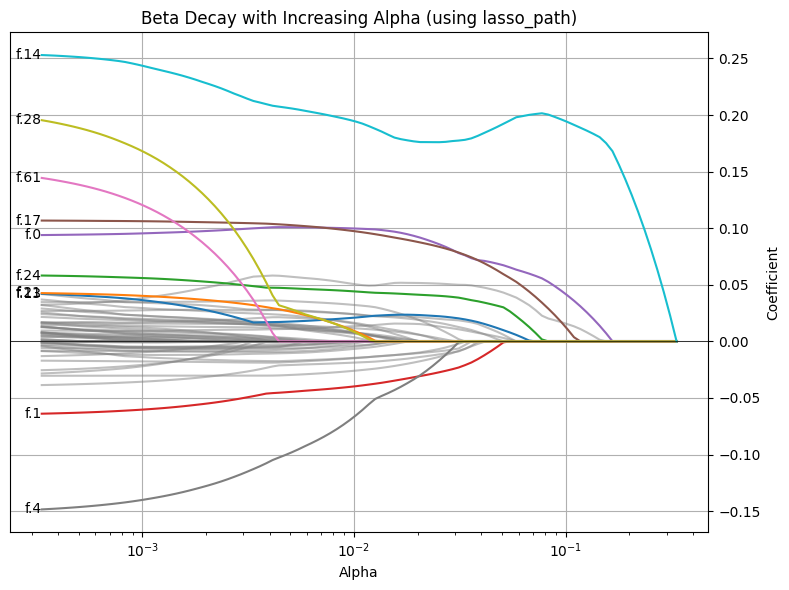

f.13: competitors_weighted_mean_log_price_per_sqm_upper
f.21: banos_recat
f.24: conservacion_recat
f.1: edad_anios
f.0: id_clase_inmueble
f.17: quarters_since_first_appraisal
f.61: id_tipo_inmueble_4
f.4: superficie_vendible
f.28: superficie_terreno_usable
f.14: mean_log_valor_fisico_terreno_m2


In [22]:
# visualize scaled
visualize_beta_decay(X_train, y_train, n_highlight=10)

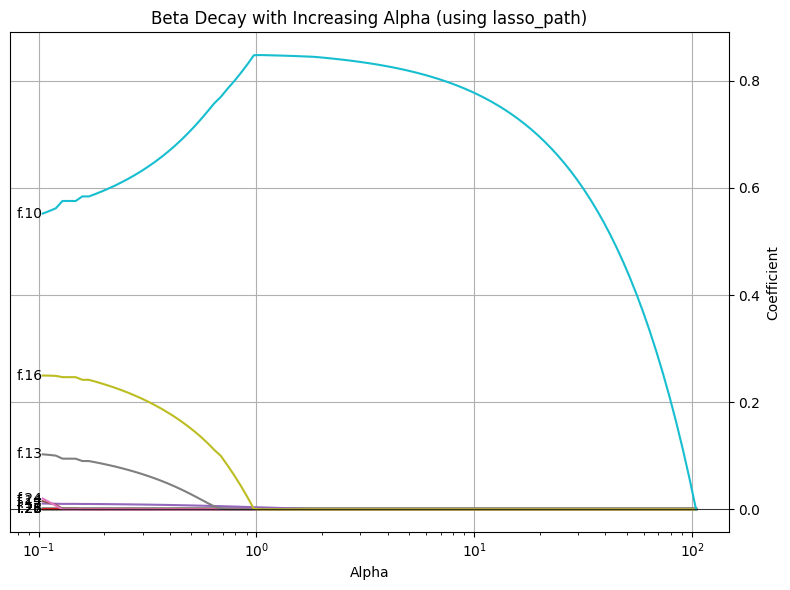

f.25: cve_vigilancia_recat
f.26: regimen_propiedad_colectiva
f.27: distance_to_ocean_recat
f.28: superficie_terreno_usable
f.17: quarters_since_first_appraisal
f.14: mean_log_valor_fisico_terreno_m2
f.24: conservacion_recat
f.13: competitors_weighted_mean_log_price_per_sqm_upper
f.16: mean_log_valor_fisico_terreno_m2_upper
f.10: ing_cor


In [23]:
# visualize not scaled
visualize_beta_decay(
    X_train,
    y_train,
    n_highlight=10,
    scale=False
    )

In [24]:
X_train['ing_cor'].describe()

count    767621.000000
mean         11.011817
std           0.279930
min           9.774713
25%          10.848236
50%          11.002653
75%          11.184160
max          13.257967
Name: ing_cor, dtype: float64

---
# Feature Selection Random Forest

## Split Data

In [25]:
df_properties.columns

Index(['fecha_avaluo', 'id_clase_inmueble', 'conservacion', 'elevador',
       'cve_ref_proximidad_urbana', 'valor_mercado', 'edad_anios',
       'cve_vigilancia', 'regimen_propiedad', 'tipo_vialidad', 'recamaras',
       'banos', 'medio_banos', 'estacionamiento', 'superficie_terreno',
       'superficie_construida', 'superficie_accesoria', 'superficie_vendible',
       'city_cluster', 'distance_to_ocean', 'ocean_label', 'longitud',
       'latitud', 'count_supermarkets_at_1km', 'count_hospitals_at_5km',
       'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km', 'ing_cor',
       'competitors_weighted_mean_log_price_per_sqm',
       'competitors_weighted_mean_log_price_per_sqm_lower',
       'competitors_weighted_mean_log_price_per_sqm_upper',
       'mean_log_valor_fisico_terreno_m2',
       'mean_log_valor_fisico_terreno_m2_lower',
       'mean_log_valor_fisico_terreno_m2_upper', 'price_per_sqm',
       'quarters_since_first_appraisal', 'elevador_recat', 

In [ ]:
# get important columns
cols_for_model = [
    'id_clase_inmueble',
    'edad_anios',
    'cve_vigilancia',
    'superficie_accesoria',
    'superficie_vendible',
    'count_supermarkets_at_1km',
    'count_hospitals_at_5km',
    'count_metro_at_1km',
    'count_schools_at_1km',
    'count_restaurants_at_1km',
    'ing_cor',
    'competitors_weighted_mean_log_price_per_sqm',
    'competitors_weighted_mean_log_price_per_sqm_lower',
    'competitors_weighted_mean_log_price_per_sqm_upper',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper', 
    'quarters_since_first_appraisal',
    'elevador',
    'is_new',
    'recamaras',
    'banos',
    'medio_banos',
    'estacionamiento',
    'conservacion_recat',
    'cve_vigilancia_recat',
    'regimen_propiedad_colectiva',
    'distance_to_ocean',
    'superficie_terreno_usable',
    'longitud',
    'latitud'
]

X = df_properties[cols_for_model].copy()
y = df_properties['log_price_per_sqm'].copy()

In [ ]:
def visualize_feature_importance(rf_model, n_highlight=5):
    """
    Visualize feature importances from a Random Forest model.
    Highlights top performing features by their index.
    """
    # Get feature importances
    importances = rf_model.feature_importances_
    feature_indices = np.argsort(importances)[::-1]  # Sort in descending order

    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': [f'Feature {i}' for i in range(len(importances))],
        'Importance': importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plotting
    _, ax = plt.subplots(figsize=(12, 8))

    # Plot all features in gray
    ax.bar(importance_df['Feature'], importance_df['Importance'], color='gray', alpha=0.5)

    # Highlight top features
    top_features = importance_df.head(n_highlight)
    ax.bar(top_features['Feature'], top_features['Importance'], color='blue')

    # Annotate top features
    for i, (feature, importance) in enumerate(zip(top_features['Feature'], top_features['Importance'])):
        feature_index = int(feature.split()[-1])
        ax.text(i, importance, f'Feature {feature_index}', ha='center', va='bottom')

    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    ax.set_title('Random Forest Feature Importance')
    ax.set_xticks([])  # Remove x-axis labels for clarity

    plt.tight_layout()
    plt.show()


---
# Sandbox